### RNN - LSTM - NLP

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import nltk
import warnings
warnings.filterwarnings('ignore')
from html.parser import HTMLParser
html_parser = HTMLParser()
import re

In [5]:
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

In [6]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import os
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn import utils
from sklearn.linear_model import LogisticRegression

### Data overview

In [7]:
df = pd.read_json('Clothing_Shoes_and_Jewelry_5.json', lines=True)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [8]:
df.tail()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
278672,A2DG63DN704LOI,B00KKXCJQU,ESlayd,"[0, 1]",I don't normally go ga-ga over a product very ...,5,These have literally changed the way I travel!,1403568000,"06 24, 2014"
278673,A1EVV74UQYVKRY,B00KKXCJQU,K. Groh,"[0, 0]",I've been traveling back and forth to England ...,5,Wonderful for Better Packing,1403740800,"06 26, 2014"
278674,A1UQBFCERIP7VJ,B00KKXCJQU,Margaret Picky,"[1, 1]",These are very nice packing cubes and the 18 x...,5,"Convenient, lightweight, and durable",1402185600,"06 8, 2014"
278675,A22CW0ZHY3NJH8,B00KKXCJQU,Noname,"[2, 2]",I am on vacation with my family of four and th...,5,Holds Up Well In Real World Test,1404691200,"07 7, 2014"
278676,A30VWT3R25QAVD,B00KKXCJQU,"THE-DEADLY-DOG ""Living and Loving Life.""","[0, 1]",When I signed up to receive a free set of Shac...,5,Don't Travel? Still Way too Useful for 'Averag...,1403481600,"06 23, 2014"


In [9]:
df['overall'].value_counts()

5    163240
4     58357
3     30425
2     15463
1     11192
Name: overall, dtype: int64

In [10]:
sentiment = lambda x: 'Positive' if x>3 else 'Neutral' if x==3 else 'Negative'

In [11]:
df['sentiment'] = df['overall'].apply(sentiment)

In [12]:
df['sentiment'].value_counts()

Positive    221597
Neutral      30425
Negative     26655
Name: sentiment, dtype: int64

In [13]:
df[['reviewText','summary','overall','sentiment']]

,reviewText,summary,overall,sentiment
0,This is a great tutu and at a really great pri...,Great tutu- not cheaply made,5,Positive
1,I bought this for my 4 yr old daughter for dan...,Very Cute!!,5,Positive
2,What can I say... my daughters have it in oran...,I have buy more than one,5,Positive
3,"We bought several tutus at once, and they are ...","Adorable, Sturdy",5,Positive
4,Thank you Halo Heaven great product for Little...,Grammy's Angels Love it,5,Positive
...,...,...,...,...
278672,I don't normally go ga-ga over a product very ...,These have literally changed the way I travel!,5,Positive
278673,I've been traveling back and forth to England ...,Wonderful for Better Packing,5,Positive
278674,These are very nice packing cubes and the 18 x...,"Convenient, lightweight, and durable",5,Positive
278675,I am on vacation with my family of four and th...,Holds Up Well In Real World Test,5,Positive


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


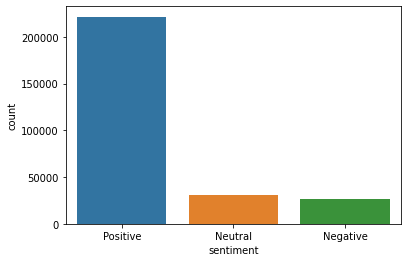

In [14]:
sns.countplot(data=df, x='sentiment')

### Preprocessing text

In [15]:
# preprocessing

# remove hltm format
df['clean'] = df['reviewText'].apply(lambda x: html_parser.unescape(x))
#lower case
df['clean'] = df['clean'].apply(lambda x: x.lower())

In [16]:
apostrophe_dict = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [17]:
# apostrophe lookup
def lookup_dict(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [18]:
df['clean'] = df['clean'].apply(lambda x: lookup_dict(x,apostrophe_dict))

In [19]:
short_word_dict = {
"121": "one to one",
"a/s/l": "age, sex, location",
"adn": "any day now",
"afaik": "as far as I know",
"afk": "away from keyboard",
"aight": "alright",
"alol": "actually laughing out loud",
"b4": "before",
"b4n": "bye for now",
"bak": "back at the keyboard",
"bf": "boyfriend",
"bff": "best friends forever",
"bfn": "bye for now",
"bg": "big grin",
"bta": "but then again",
"btw": "by the way",
"cid": "crying in disgrace",
"cnp": "continued in my next post",
"cp": "chat post",
"cu": "see you",
"cul": "see you later",
"cul8r": "see you later",
"cya": "bye",
"cyo": "see you online",
"dbau": "doing business as usual",
"fud": "fear, uncertainty, and doubt",
"fwiw": "for what it's worth",
"fyi": "for your information",
"g": "grin",
"g2g": "got to go",
"ga": "go ahead",
"gal": "get a life",
"gf": "girlfriend",
"gfn": "gone for now",
"gmbo": "giggling my butt off",
"gmta": "great minds think alike",
"h8": "hate",
"hagn": "have a good night",
"hdop": "help delete online predators",
"hhis": "hanging head in shame",
"iac": "in any case",
"ianal": "I am not a lawyer",
"ic": "I see",
"idk": "I don't know",
"imao": "in my arrogant opinion",
"imnsho": "in my not so humble opinion",
"imo": "in my opinion",
"iow": "in other words",
"ipn": "I’m posting naked",
"irl": "in real life",
"jk": "just kidding",
"l8r": "later",
"ld": "later, dude",
"ldr": "long distance relationship",
"llta": "lots and lots of thunderous applause",
"lmao": "laugh my ass off",
"lmirl": "let's meet in real life",
"lol": "laugh out loud",
"ltr": "longterm relationship",
"lulab": "love you like a brother",
"lulas": "love you like a sister",
"luv": "love",
"m/f": "male or female",
"m8": "mate",
"milf": "mother I would like to fuck",
"oll": "online love",
"omg": "oh my god",
"otoh": "on the other hand",
"pir": "parent in room",
"ppl": "people",
"r": "are",
"rofl": "roll on the floor laughing",
"rpg": "role playing games",
"ru": "are you",
"shid": "slaps head in disgust",
"somy": "sick of me yet",
"sot": "short of time",
"thanx": "thanks",
"thx": "thanks",
"ttyl": "talk to you later",
"u": "you",
"ur": "you are",
"uw": "you’re welcome",
"wb": "welcome back",
"wfm": "works for me",
"wibni": "wouldn't it be nice if",
"wtf": "what the fuck",
"wtg": "way to go",
"wtgp": "want to go private",
"ym": "young man",
"gr8": "great"
}

In [20]:
# short word lookup
df['clean'] = df['clean'].apply(lambda x: lookup_dict(x,short_word_dict))

In [21]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [22]:
# emoticon lookup
df['clean'] = df['clean'].apply(lambda x: lookup_dict(x,emoticon_dict))

In [23]:
#  replacing punctuations with space
df['clean'] = df['clean'].apply(lambda x: re.sub(r'[^\w\s]',' ',x))

In [24]:
# replacing special characters
df['clean'] = df['clean'].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))

In [25]:
# remove number
df['clean'] = df['clean'].apply(lambda x: re.sub(r'[^a-zA-Z]',' ',x))

In [26]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [27]:
# create token
df['text_token'] = df['clean'].apply(lambda x: word_tokenize(x))

In [28]:
df[['reviewText','clean','text_token']]

,reviewText,clean,text_token
0,This is a great tutu and at a really great pri...,this is a great tutu and at a really great pri...,"[this, is, a, great, tutu, and, at, a, really,..."
1,I bought this for my 4 yr old daughter for dan...,i bought this for my yr old daughter for dan...,"[i, bought, this, for, my, yr, old, daughter, ..."
2,What can I say... my daughters have it in oran...,what can i say my daughters have it in oran...,"[what, can, i, say, my, daughters, have, it, i..."
3,"We bought several tutus at once, and they are ...",we bought several tutus at once and they are ...,"[we, bought, several, tutus, at, once, and, th..."
4,Thank you Halo Heaven great product for Little...,thank you halo heaven great product for little...,"[thank, you, halo, heaven, great, product, for..."
...,...,...,...
278672,I don't normally go ga-ga over a product very ...,i do not normally go ga ga over a product very...,"[i, do, not, normally, go, ga, ga, over, a, pr..."
278673,I've been traveling back and forth to England ...,I have been traveling back and forth to englan...,"[I, have, been, traveling, back, and, forth, t..."
278674,These are very nice packing cubes and the 18 x...,these are very nice packing cubes and the x...,"[these, are, very, nice, packing, cubes, and, ..."
278675,I am on vacation with my family of four and th...,i am on vacation with my family of four and th...,"[i, am, on, vacation, with, my, family, of, fo..."


In [29]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [30]:
stop_words = set(stopwords.words('english'))

In [31]:
df['text_token_stopword'] = df['text_token'].apply(lambda x: [word for word in x if not word in stop_words])

In [32]:
stemming = PorterStemmer()
lemmatizing = WordNetLemmatizer()

In [33]:
df['text_stemmed'] = df['text_token_stopword'].apply(lambda x: ' '.join([stemming.stem(i) for i in x]))

In [34]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [35]:
df['text_lematized'] = df['text_token_stopword'].apply(lambda x: ' '.join([lemmatizing.lemmatize(i) for i in x]))

### Sentiment Analysis

In [36]:
# df_1 = df.sample(frac = 0.7)
# df_2 = df.drop(df_1.index)

In [37]:
sentiment  = {'Positive': 0,'Neutral': 1,'Negative':2} 
df.sentiment = [sentiment[item] for item in df.sentiment] 

In [38]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,sentiment,clean,text_token,text_token_stopword,text_stemmed,text_lematized
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011",0,this is a great tutu and at a really great pri...,"[this, is, a, great, tutu, and, at, a, really,...","[great, tutu, really, great, price, look, chea...",great tutu realli great price look cheap i gla...,great tutu really great price look cheap I gla...
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013",0,i bought this for my yr old daughter for dan...,"[i, bought, this, for, my, yr, old, daughter, ...","[bought, yr, old, daughter, dance, class, wore...",bought yr old daughter danc class wore today f...,bought yr old daughter dance class wore today ...
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013",0,what can i say my daughters have it in oran...,"[what, can, i, say, my, daughters, have, it, i...","[say, daughters, orange, black, white, pink, t...",say daughter orang black white pink think buy ...,say daughter orange black white pink thinking ...
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014",0,we bought several tutus at once and they are ...,"[we, bought, several, tutus, at, once, and, th...","[bought, several, tutus, got, high, reviews, s...",bought sever tutu got high review sturdi seemi...,bought several tutu got high review sturdy see...
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014",0,thank you halo heaven great product for little...,"[thank, you, halo, heaven, great, product, for...","[thank, halo, heaven, great, product, little, ...",thank halo heaven great product littl girl gre...,thank halo heaven great product little girl gr...


In [39]:
dataset = df[['text_lematized','sentiment']]
dataset.head()

,text_lematized,sentiment
0,great tutu really great price look cheap I gla...,0
1,bought yr old daughter dance class wore today ...,0
2,say daughter orange black white pink thinking ...,0
3,bought several tutu got high review sturdy see...,0
4,thank halo heaven great product little girl gr...,0


In [40]:
train, test = train_test_split(dataset, test_size=0.000001 , random_state=13)

In [41]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text_lematized']), tags=[r.sentiment]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text_lematized']), tags=[r.sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text_lematized'].values)
X = tokenizer.texts_to_sequences(df['text_lematized'].values)
X = pad_sequences(X)
print('Found %s unique tokens.' % len(X))

Found 278677 unique tokens.


In [42]:
X = tokenizer.texts_to_sequences(df['text_lematized'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (278677, 50)


In [43]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 278676/278676 [00:00<00:00, 2516923.80it/s]


In [44]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 278676/278676 [00:00<00:00, 3018370.39it/s]


CPU times: user 11min 14s, sys: 3.07 s, total: 11min 17s
Wall time: 11min 12s


In [45]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [46]:
# save the vectors in a new matrix
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
    #print(i)
    #print(model.docvecs)
          embedding_matrix[i]=vec

In [47]:
# LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

# init layer
model = Sequential()
# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))
# learn the correlations
def split_input(sequence):
     return sequence[:-1], np.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

In [48]:
# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 20)            1374560   
                                                                 
 lstm (LSTM)                 (None, 50)                14200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 1,388,913
Trainable params: 1,388,913
Non-trainable params: 0
_________________________________________________________________


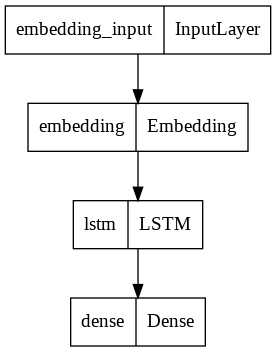

In [49]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [50]:
Y = pd.get_dummies(df['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(236875, 50) (236875, 3)
(41802, 50) (41802, 3)


In [51]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
7403/7403 - 46s - loss: 0.2608 - acc: 0.8323 - 46s/epoch - 6ms/step
Epoch 2/50
7403/7403 - 39s - loss: 0.2290 - acc: 0.8501 - 39s/epoch - 5ms/step
Epoch 3/50
7403/7403 - 41s - loss: 0.2144 - acc: 0.8598 - 41s/epoch - 6ms/step
Epoch 4/50
7403/7403 - 40s - loss: 0.2005 - acc: 0.8693 - 40s/epoch - 5ms/step
Epoch 5/50
7403/7403 - 39s - loss: 0.1873 - acc: 0.8792 - 39s/epoch - 5ms/step
Epoch 6/50
7403/7403 - 39s - loss: 0.1744 - acc: 0.8877 - 39s/epoch - 5ms/step
Epoch 7/50
7403/7403 - 40s - loss: 0.1614 - acc: 0.8968 - 40s/epoch - 5ms/step
Epoch 8/50
7403/7403 - 41s - loss: 0.1492 - acc: 0.9045 - 41s/epoch - 5ms/step
Epoch 9/50
7403/7403 - 39s - loss: 0.1372 - acc: 0.9127 - 39s/epoch - 5ms/step
Epoch 10/50
7403/7403 - 39s - loss: 0.1271 - acc: 0.9191 - 39s/epoch - 5ms/step
Epoch 11/50
7403/7403 - 39s - loss: 0.1174 - acc: 0.9256 - 39s/epoch - 5ms/step
Epoch 12/50
7403/7403 - 41s - loss: 0.1089 - acc: 0.9309 - 41s/epoch - 6ms/step
Epoch 13/50
7403/7403 - 40s - loss: 0.1011 - acc:

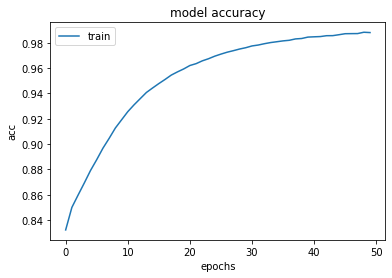

In [52]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

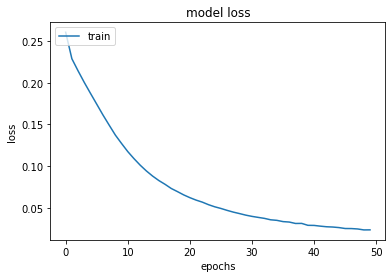

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Nhan xet: model co acc cao, loss thap, co the su dung.

In [54]:
#evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

7403/7403 - 26s - loss: 0.0185 - acc: 0.9908 - 26s/epoch - 4ms/step
1307/1307 - 4s - loss: 1.0538 - acc: 0.7913 - 4s/epoch - 3ms/step
Train: 0.991, Test: 0.7913


### Test

In [81]:
text_2 = "The title says it all. I loved these, but you literally have to wrestle your kid and near mangle his feet, even when a size or two too big- to get them on. THEN you have to lace and tie them! On a kicking toddler! Yeah, right! IMPOSSIBLE to get on for the most part. And don't seem comfortable either. they need to create this same shoe, but but an easy access ZIPPER on the side, down to the toe bed to get the young child's foot inside."
text_1 = "My 3yr old loved this tutu skirt in pink! Was hoping to order more in different colors.She had hardly used this,the stitching came apart in 2weeks.now it's lying in her closet..Altogether she wore it like 4-5 times for 20 mins or so.wish the stitching was of better quality to hold up while little ones wear it. Can't recommend."
text_0 = 'We bought several tutus at once, and they are got high reviews. Sturdy and seemingly well-made. The girls have been wearing them regularly, including out to play, and the tutus have stood up well. Fits the 3-yr old & the 5-yr old well. Clearly plenty of room to grow. Only con is that when the kids pull off the tutus, the waste band gets twisted, and an adult has to un-tangle. But this is not difficult.'

In [82]:
# sentiment = {'positive': 0,'neutral': 1,'negative':2}
labels = ['0','1','2']

In [83]:
seq = tokenizer.texts_to_sequences([text_2])
padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)
pred = model.predict(padded)
print(pred, 'Predict: ', labels[np.argmax(pred)])

1/1 [==============================] - 0s 19ms/step
[[3.9658596e-09 3.0686411e-07 9.9999964e-01]] Predict:  2


In [84]:
seq = tokenizer.texts_to_sequences([text_1])
padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)
pred = model.predict(padded)
print(pred, 'Predict: ',labels[np.argmax(pred)])

1/1 [==============================] - 0s 18ms/step
[[1.7215691e-05 9.9998283e-01 5.4000755e-11]] Predict:  1


In [85]:
seq = tokenizer.texts_to_sequences([text_0])
padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)
pred = model.predict(padded)
print(pred, 'Predict: ',labels[np.argmax(pred)])

1/1 [==============================] - 0s 15ms/step
[[1.0000000e+00 6.6920319e-14 2.4630498e-10]] Predict:  0


Nhan xet: model du doan dung 3/3 vi du. Hoat dong tot.